In [1]:
from pyFTS.partitioners import CMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from pyFTS.partitioners import Grid, partitioner
from pyFTS.common import FLR
from pyFTS.models import chen, cheng, hofts, tsaur
from pyFTS.common import Util
from pyFTS.common import Transformations

from scipy.optimize import fsolve
import numpy as np
import fuzzylab as fz
from fuzzylab.evalmf import evalmf

from collections import defaultdict

In [2]:
data = pd.read_csv('./data/A17U-SI.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-10-31,1.514444,1.650356,1.514444,1.533860,0.625674,5103019
1,2008-11-03,1.630940,1.776559,1.630940,1.747436,0.712794,5438825
2,2008-11-04,1.698896,1.747436,1.630940,1.640648,0.669234,4405654
3,2008-11-05,1.679480,1.776559,1.660064,1.766851,0.720713,3008865
4,2008-11-06,1.601816,1.698896,1.572692,1.689188,0.689034,3841170


In [3]:
# Isolate Target Columns
df = data.loc[:, ['Date', 'Close']]
df.set_index('Date', inplace=True)

# Set to date-time index
df.index = pd.to_datetime(df.index)
df = df.asfreq('D')
df

,Close
Date,
2008-10-31,1.533860
2008-11-01,NaN
2008-11-02,NaN
2008-11-03,1.747436
2008-11-04,1.640648
...,...
2023-10-26,2.500000
2023-10-27,2.510000
2023-10-28,NaN


In [4]:
# Default option: use last observed data point
df.fillna(method='ffill', inplace=True)

<AxesSubplot:title={'center':'A17U.SI Time Series'}, xlabel='Date'>

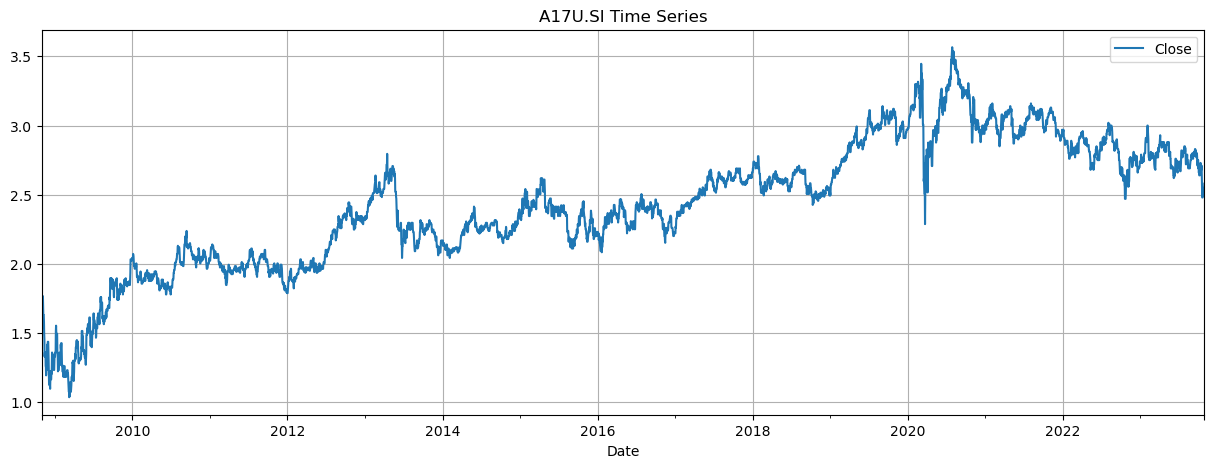

In [5]:
df.plot(title='A17U.SI Time Series',figsize=(15,5), grid=True)

In [6]:
# Data Partitioning and MF generation
n_partitions = 200

train = df.values.reshape(-1,)[:-365]
test = df.values.reshape(-1,)[-365:]
test_lagged = df.values.reshape(-1,)[-366:-1]

# Apply Differencing to make data stationary
# train_orig = train.copy()
# test_orig = test.copy()
# train = pd.Series(train).diff()[1:].reset_index(drop=True).values.reshape(-1,)
# test = pd.Series(test).diff()[1:].reset_index(drop=True).values.reshape(-1,)


### Fuzzy CMeans

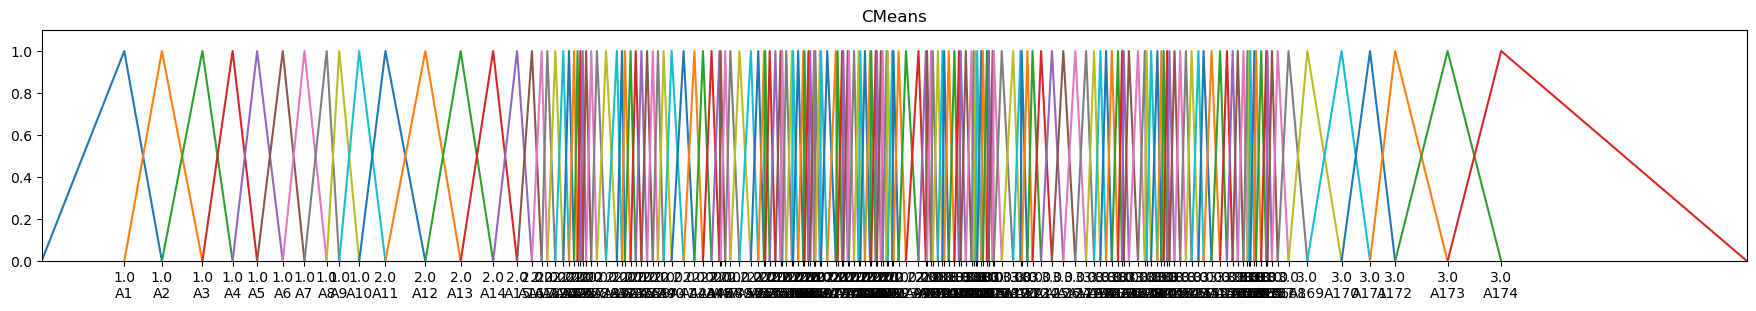

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[22,3])
part = CMeans.CMeansPartitioner(data=train, npart=n_partitions)
part.plot(ax)

In [8]:
model = cheng.TrendWeightedFTS(partitioner=part)
model.fit(train)
print(model)

Trend Weighted FTS:
A1 -> A1(0.018),A1(0.036),A1(0.055),A1(0.073),A1(0.091),A1(0.109),A1(0.127),A2(0.145),A2(0.164),A2(0.182)
A2 -> A1(0.007),A1(0.013),A1(0.02),A2(0.026),A2(0.033),A2(0.039),A2(0.046),A2(0.052),A2(0.059),A2(0.065),A2(0.072),A2(0.078),A2(0.085),A3(0.092),A3(0.098),A3(0.105),A3(0.111)
A3 -> A2(0.001),A2(0.002),A2(0.003),A3(0.004),A3(0.004),A3(0.005),A3(0.006),A3(0.007),A3(0.008),A3(0.009),A3(0.01),A3(0.011),A3(0.012),A3(0.012),A3(0.013),A3(0.014),A3(0.015),A3(0.016),A3(0.017),A3(0.018),A3(0.019),A3(0.02),A3(0.02),A3(0.021),A3(0.022),A3(0.023),A3(0.024),A3(0.025),A3(0.026),A3(0.027),A3(0.027),A3(0.028),A3(0.029),A3(0.03),A3(0.031),A3(0.032),A3(0.033),A3(0.034),A3(0.035),A3(0.035),A4(0.036),A4(0.037),A4(0.038),A4(0.039),A4(0.04),A5(0.041),A5(0.042)
A4 -> A3(0.004),A3(0.008),A3(0.012),A3(0.016),A4(0.02),A4(0.024),A4(0.028),A4(0.032),A4(0.036),A4(0.04),A4(0.043),A4(0.047),A4(0.051),A4(0.055),A5(0.059),A5(0.063),A5(0.067),A5(0.071),A5(0.075),A6(0.079),A6(0.083),A8(0.087)
A5 -

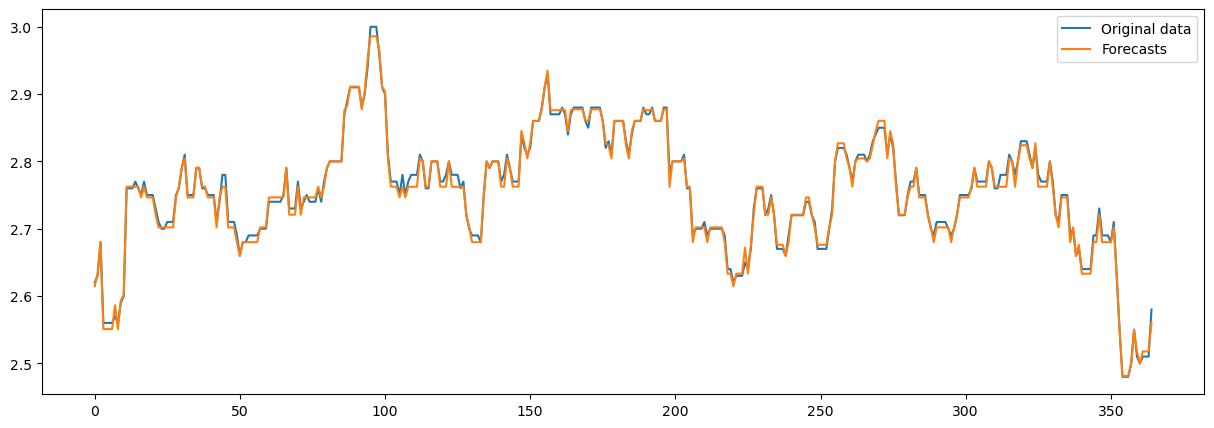

In [9]:
# Predict and Plot Results
test_diff = pd.DataFrame(test).diff().values.reshape(-1,)[1:]

##
forecasts = model.predict(test)
##


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])
orig, = plt.plot(test, label="Original data",)
pred, = plt.plot(forecasts, label="Forecasts")

plt.legend(handles=[orig, pred])

In [10]:
# # CODE FROM PYFTS
# train = df.values.reshape(-1,)[:-365]
# test = df.values.reshape(-1,)[-365:]

# diff = Transformations.Differential(1)

# part1 = Grid.GridPartitioner(data=train, npart=15, transformation=diff)
# part2 = Grid.GridPartitioner(data=train, npart=15)

# model1 = chen.ConventionalFTS(partitioner=part1)
# model1.append_transformation(diff)
# model1.fit(train)

# model2 = chen.ConventionalFTS(partitioner=part2)
# model2.fit(train)

# forecasts1 = model1.predict(test)
# forecasts2 = model2.predict(test)

# fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

# ax.plot(test, 'b', label='Original')
# ax.plot(forecasts1, 'r', label='With transformation')
# #ax.plot(forecasts2, label='Without transformation')

# handles, labels = ax.get_legend_handles_labels()
# lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))